In [1]:
import itertools
import typing
import numpy as np
import matplotlib.pyplot as plt

from gym import Env, spaces
from neuronav.envs.graph_env import GraphObsType
import neuronav.utils as utils
from neuronav.agents.base_agent import BaseAgent
from neuronav.agents.td_agents import TDQ, TDAC
from neuronav.notebook_helpers import AgentParams

import gym_minigrid
from gym_minigrid.envs import numbertasks
from gym_minigrid.envs.numbertasks import NumberTaskType

In [2]:
N_STATES = 20
SINGLE_TASK_N_ACTIONS = 2
NEURONAV_DEFAULT_RESET_KEYS = ('agent_pos', 'reward_locs', 'random_start')

class NumberTasksEnv(Env):
    def __init__(self, task: NumberTaskType, obs_type: GraphObsType = GraphObsType.index, 
        switch_tasks: bool = False, multi_task: bool = False, remap_actions: bool = False, seed: int = 33):
        self.task = task
        self.obs_type = obs_type

        self.switch_tasks = switch_tasks
        self.multi_task = multi_task
        self.remap_actions = remap_actions

        self.seed = seed
        self.rng = np.random.RandomState(seed)

        self.n_actions = SINGLE_TASK_N_ACTIONS if self.multi_task else SINGLE_TASK_N_ACTIONS * len(NumberTaskType)
        self.action_permutations = list(itertools.permutations(range(self.n_actions))) if self.remap_actions else [list(range(self.n_actions))]
        self.n_action_permutations = len(self.action_permutations)
        self.state_size = N_STATES * self.n_action_permutations

        if obs_type == GraphObsType.index:
            self.observation_space = spaces.Box(0, self.state_size, shape=(1,), dtype=np.int32)

        elif obs_type == GraphObsType.onehot:
            self.observation_space = spaces.Box(0, 1, shape=(self.state_size,), dtype=np.int32)

        elif obs_type == GraphObsType.images:
            raise ValueError('Not implemented')

        self.action_space = spaces.Discrete(self.n_actions)

        self.last_stimulus = None
        self.action_permutation_index = 0
        

    def reset(self, seed: typing.Optional[int] = None, **kwargs):
        for key in NEURONAV_DEFAULT_RESET_KEYS:
            if key in kwargs:
                kwargs.pop(key)

        super().reset(seed=seed, **kwargs)
        return self.observation

    @property
    def observation(self):
        if self.switch_tasks:
            self.task = self.rng.choice(list(NumberTaskType))

        if self.remap_actions:
            self.action_permutation_index = self.rng.randint(0, self.n_action_permutations)

        self.last_stimulus = self.rng.randint(0, N_STATES) + (self.action_permutation_index * N_STATES)
        
        if self.obs_type == GraphObsType.onehot:
            return utils.onehot(self.last_stimulus, self.state_size)
        elif self.obs_type == GraphObsType.index:
            return self.last_stimulus
        else:
            return None

    def step(self, action: int):
        """
        Assumes that 0-9 are the digits in red and 10-19 are the digits in green
        Color task: 0 is red, 1 is green
        Magnitude task: 0 is -, 1 is +
        Parity task: 0 is even, 1 is odd
        """
        if self.last_stimulus is None:
            raise ValueError('No stimulus has been set yet')

        stimulus = self.last_stimulus % N_STATES
        action_permutation = self.action_permutations[self.action_permutation_index]
        action = action_permutation[action]

        if self.multi_task:
            if self.task == NumberTaskType.color and action < 2:
                reward = 1 if (stimulus >= 10) == (action == 1) else -1

            elif self.task == NumberTaskType.magnitude and 2 < action < 4:
                action -= 2
                digit = stimulus % 10
                reward = 1 if (digit >= 5) == (action == 1) else -1

            elif self.task == NumberTaskType.parity and action >= 4:
                action -= 4
                reward = 1 if (stimulus % 2) == action else -1
            
            else: 
                reward = -1

        else:
            if self.task == NumberTaskType.color:
                reward = 1 if (stimulus >= 10) == (action == 1) else -1

            elif self.task == NumberTaskType.magnitude:
                digit = stimulus % 10
                reward = 1 if (digit >= 5) == (action == 1) else -1

            elif self.task == NumberTaskType.parity:
                reward = 1 if (stimulus % 2) == action else -1
        
        return self.observation, reward, False, {}

In [33]:
AGENT_PARAMS = AgentParams(
    poltype="softmax",
    beta=2.0,
    epsilon=0.1,
    lr=1e-1,
    gamma=0,
)

N_STEPS = 10000

AGENT_TYPES = {'TDQ': TDQ, 'TDAC': TDAC}


In [34]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


def run_and_plot_multiple_agents(env: Env, agent_types: typing.Dict[str, typing.Type[BaseAgent]] = AGENT_TYPES,
    agent_params: AgentParams = AGENT_PARAMS, n_steps: int = N_STEPS, moving_average_window: int = 100,
    ax: typing.Optional[plt.Axes] = None, title: str = '', 
    show_legend: bool = True, legend_loc: str = 'best',):
    
    agent_rewards = {}
    agents = {}

    for agent_type, agent_class in agent_types.items():
        agent = agent_class(env.state_size, env.action_space.n, **agent_params.__dict__)
        agent, _, rewards = utils.run_episode(env, agent, n_steps, track_rewards=True)
        agent_rewards[agent_type] = moving_average(rewards, moving_average_window)
        agents[agent_type] = agent

    if ax is None:
        _, ax = plt.subplots()

    for agent_type, agent_rewards in agent_rewards.items():
        ax.plot(agent_rewards, label=agent_type)

    if show_legend:
        ax.legend(loc=legend_loc)

    ax.set_xlabel('Steps')
    ax.set_ylabel(f'Reward ({moving_average_window}-step average)')
    ax.set_title(title)

    return agents

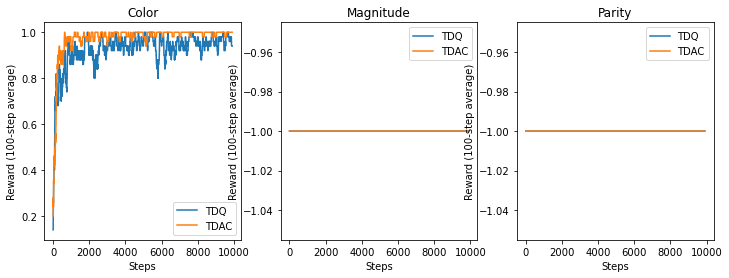

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for index, task in enumerate(NumberTaskType):
    ax = axes[index]
    env = NumberTasksEnv(task=task, obs_type=GraphObsType.index)
    agents = run_and_plot_multiple_agents(env, ax=ax, title=task.name.capitalize())

{0: 0.54, 1: 0.5, 2: 0.55, 3: 0.47, 4: 0.45, 5: 0.47, 6: 0.6, 7: 0.54, 8: 0.51, 9: 0.48, 10: 0.45, 11: 0.58, 12: 0.45, 13: 0.49, 14: 0.49, 15: 0.49, 16: 0.44, 17: 0.54, 18: 0.46, 19: 0.53}


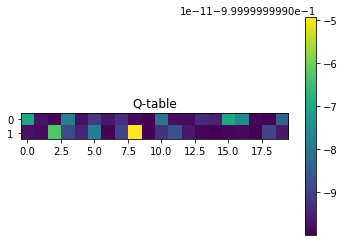

In [37]:
sampled_actions = {
    s: np.mean([agents['TDQ'].sample_action(s) for _ in range(100)])
    for s in range(N_STATES)
}
print(sampled_actions)
    

plt.imshow(agents['TDQ'].Q)
plt.colorbar()
plt.title(f'Q-table')
plt.show()

In [ ]:
task_switch_env = NumberTasksEnv(task=task, obs_type=GraphObsType.index, switch_tasks=True)
task_switch_q_agent = TDQ(task_switch_env.state_size, task_switch_env.action_space.n, **AGENT_PARAMS.__dict__)

utils.run_episode(task_switch_env, task_switch_q_agent, N_STEPS * 10)
plt.imshow(task_switch_q_agent.Q)
plt.colorbar()
plt.title(f'Task Switching Q-table')
plt.show()

In [ ]:
multi_task_switch_env = NumberTasksEnv(task=task, obs_type=GraphObsType.index, switch_tasks=True, multi_task=True)
multi_task_switch_q_agent = TDQ(multi_task_switch_env.state_size, multi_task_switch_env.action_space.n, **AGENT_PARAMS.__dict__)

utils.run_episode(multi_task_switch_env, multi_task_switch_q_agent, N_STEPS * 10)
plt.imshow(multi_task_switch_q_agent.Q)
plt.colorbar()
plt.title(f'Task Switching with multiple outputs Q-table')
plt.show()

In [38]:
env = NumberTasksEnv(task=NumberTaskType.parity, obs_type=GraphObsType.index)
env.reset()

7

In [43]:
env.step(1)